_Implementing attention model on dense layer, after LSTM failed dramatically._

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd

from keras.layers import Conv1D,Dense, Recurrent, Embedding, Flatten, GlobalMaxPool1D, LSTM, Input, merge
from keras.models import Model, load_model, save_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer

from keras.layers import merge, multiply, add
from keras.layers.core import *
from keras.models import *
from keras.optimizers import SGD


# from attention_utils import get_activations, get_data_recurrent

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, precision_recall_curve

# In order to include a file from another location, run the following code.
import sys
sys.path.append('../edu/Models/') 
import labeled_functions

Using TensorFlow backend.


In [2]:
X_corpus, y = labeled_functions.load_with_path(path=r"/Users/ekremguzelyel/Desktop/Assignments/Research/MLLab-IIT/edu/active_learning")
X_sequence = []
for i in X_corpus:
    X_sequence.append(text_to_word_sequence(i))
X_train_sequence, X_test_sequence, y_train, y_test = train_test_split(X_sequence, y, test_size=1./3, random_state=42)

X_train_sequence[0], y_train[0]

Labeled Data loaded.


(['if', 'it', 'is', 'being', 'bad', 'on', 'purpose'], 0)

In [3]:
# Find max_length
max_length=0
for i in X_sequence:
    max_length = [len(set(i)) if len(set(i)) > max_length else max_length][0]

# One Hot Encoding
X_corpus_one_hot = []
for i in X_corpus:
    X_corpus_one_hot.append(one_hot(i, round(max_length*1.2)))
    
# Pad Sequences 
padded_seq_corpus = pad_sequences(X_corpus_one_hot)
X_train_padded_seq, X_test_padded_seq, y_train, y_test = train_test_split(padded_seq_corpus, y,
                                                                          test_size=1./3, random_state=42) 
padded_seq_corpus.shape

(3308, 123)

In [4]:
# Attention Vector Selection
def get_data(n, input_dim, attention_column=1):
    """
    n: the number of samples to retrieve.
    input_dim: the number of dimensions of each element in the series.
    attention_column: the column linked to the target. Everything else is purely random.
    returns: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

In [5]:
import keras.backend as K
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [6]:
# Attention Set Up
# TIME_STEPS=1
input_dim = int(X_train_padded_seq.shape[1])
# inputs = Input(shape=(TIME_STEPS, input_dim,))
# a = Permute((2, 1))(inputs)
# a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
# a = Dense(TIME_STEPS, activation='softmax')(a)


# Model Set Up
inputs = Input(shape=(input_dim,))
# a_probs = Permute((2, 1), name='attention_vec')(a)
a_probs = Dense(X_train_padded_seq.shape[1], activation='softmax', name='attention_vec')(inputs)
attention_mul = add([inputs, a_probs], name='attention_mul')

attention_mul = Dense(64)(attention_mul)

output = Dense(1, activation='sigmoid')(attention_mul)
model = Model(input=[inputs], output=output)


print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 123)          0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 123)          15252       input_1[0][0]                    
__________________________________________________________________________________________________
attention_mul (Add)             (None, 123)          0           input_1[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           7936        attention_mul[0][0]              
__________

/Users/ekremguzelyel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
N=X_train_padded_seq.shape[0]
inputs_1, outputs= get_data(N,input_dim)
model.fit([inputs_1], outputs, epochs=10, batch_size=64, validation_split=0.3)

testing_inputs_1, testing_outputs = get_data(1, input_dim)
attention_vector = get_activations(model, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_vec')[0].flatten()
print('attention =', attention_vector)

Train on 1543 samples, validate on 662 samples
Epoch 1/10
1543/1543 [==============================] - 0s 215us/step - loss: 0.8342 - acc: 0.4997 - val_loss: 0.6848 - val_acc: 0.5634
Epoch 2/10
1543/1543 [==============================] - 0s 29us/step - loss: 0.6329 - acc: 0.6448 - val_loss: 0.6155 - val_acc: 0.6707
Epoch 3/10
1543/1543 [==============================] - 0s 29us/step - loss: 0.5573 - acc: 0.7459 - val_loss: 0.5717 - val_acc: 0.7387
Epoch 4/10
1543/1543 [==============================] - 0s 29us/step - loss: 0.5029 - acc: 0.8302 - val_loss: 0.5295 - val_acc: 0.7961
Epoch 5/10
1543/1543 [==============================] - 0s 32us/step - loss: 0.4570 - acc: 0.8775 - val_loss: 0.4843 - val_acc: 0.8444
Epoch 6/10
1543/1543 [==============================] - 0s 30us/step - loss: 0.4098 - acc: 0.9132 - val_loss: 0.4366 - val_acc: 0.8822
Epoch 7/10
1543/1543 [==============================] - 0s 30us/step - loss: 0.3640 - acc: 0.9579 - val_loss: 0.3901 - val_acc: 0.9230
Epoch 8

In [9]:
score_test = model.evaluate(X_test_padded_seq, y_test,)
score_train = model.evaluate(X_train_padded_seq, y_train)
score_test, score_train

2205/2205 [==============================] - 0s 19us/step


([1.3402664030235891, 0.514052583943252],
 [1.4044474614180134, 0.5274376416017139])

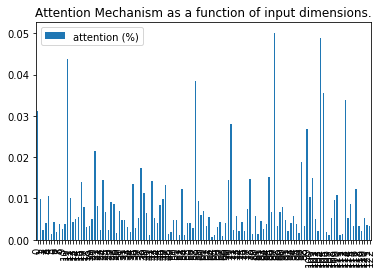

In [10]:
pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                               title='Attention Mechanism as '
                                                                     'a function of input'
                                                                     ' dimensions.')
plt.show()

__Question:__

In the source code I am taking reference, there is a function called get_data(). What it does is it takes the amount of data requested, sets the first column to y, and calls it an attention column.

How is this useful?